In [1]:
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.serialize import model_to_json, model_from_json
from prophet.diagnostics import cross_validation

In [2]:
sao_goncalo_data = pd.read_csv("data/data.csv")

sao_goncalo_data = sao_goncalo_data[sao_goncalo_data['Rio'] != 'lagoa dos patos']

sao_goncalo_data['ds'] = pd.to_datetime(sao_goncalo_data['ds'],format="%d/%m/%Y %H:%M:%S")

#sao_goncalo_data['ds'] = sao_goncalo_data['ds'].dt.strftime("%d/%m/%Y %H:%M:%S")

In [3]:
sao_goncalo_data.tail()

,ds,Rio,y
160,2024-05-16 03:00:00,sao goncalo,2.98
162,2024-05-16 04:00:00,sao goncalo,2.98
164,2024-05-16 05:00:00,sao goncalo,3.00
166,2024-05-16 06:00:00,sao goncalo,3.00
168,2024-05-16 00:00:00,sao goncalo,3.00


In [4]:
pos_wind = pd.read_csv("data/wind.csv")

pos_wind['ds'] = pd.to_datetime(pos_wind['ds'], format="%d/%m/%Y %H:%M:%S")

#pos_wind['ds'] = pos_wind['ds'].dt.strftime("%d/%m/%Y %H:%M:%S")

sao_goncalo_data = pd.merge(sao_goncalo_data, pos_wind, on="ds")

In [5]:
pos_wind.head()

,ds,pos_wind
0,2024-05-04 14:00:00,126
1,2024-05-04 20:00:00,82
2,2024-05-05 15:00:00,112
3,2024-05-05 20:00:00,82
4,2024-05-06 09:00:00,45


In [6]:
sao_goncalo_data.tail(50)

,ds,Rio,y,pos_wind
76,2024-05-13 15:00:00,sao goncalo,2.66,209
77,2024-05-13 16:00:00,sao goncalo,2.64,210
78,2024-05-13 17:00:00,sao goncalo,2.66,214
79,2024-05-13 18:00:00,sao goncalo,2.68,210
80,2024-05-13 19:00:00,sao goncalo,2.66,204
81,2024-05-13 20:00:00,sao goncalo,2.64,207
82,2024-05-13 22:00:00,sao goncalo,2.62,219
83,2024-05-13 23:00:00,sao goncalo,2.64,210
84,2024-05-14 00:00:00,sao goncalo,2.62,209
85,2024-05-14 04:00:00,sao goncalo,2.62,253


10:18:28 - cmdstanpy - INFO - Chain [1] start processing
10:18:28 - cmdstanpy - INFO - Chain [1] done processing


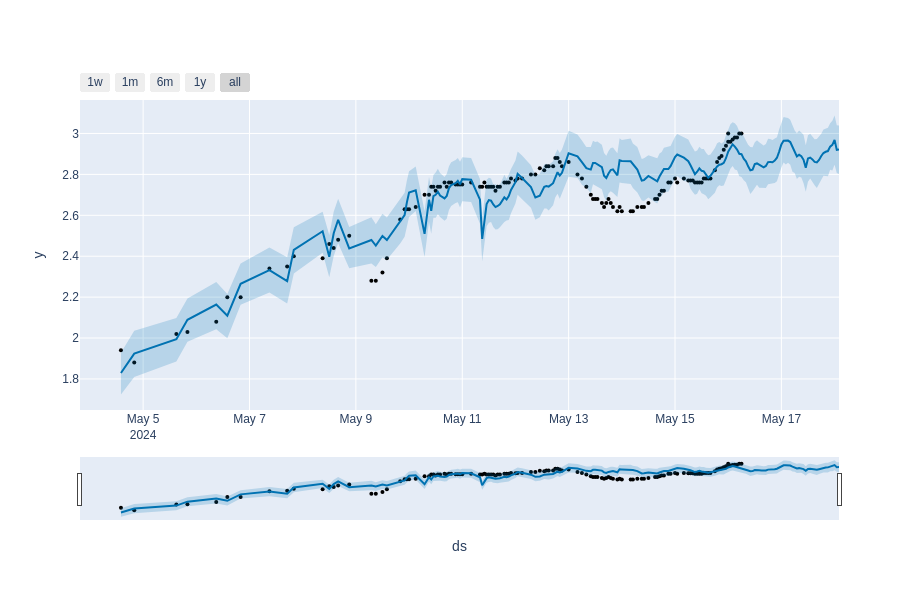

In [11]:
m = Prophet(
    yearly_seasonality=False,  
    weekly_seasonality=False,  
    daily_seasonality=True,    
    changepoint_range=0.8,     
    changepoint_prior_scale=0.9,
    changepoints=['2024-05-09 04:00:00'],
    growth="linear"         
)

# Defina os pontos de mudança
m.add_seasonality(name='daily', period=1, fourier_order=1, prior_scale = 0.01)
m.add_regressor("pos_wind", mode = "multiplicative", prior_scale = 0.8)

# Ajuste o modelo
m.fit(sao_goncalo_data)

# Realize previsões
future = m.make_future_dataframe(periods=44, freq='h')  

future['pos_wind'] = pos_wind['pos_wind']

forecast = m.predict(future)

# Visualize o resultado do modelo
plot_plotly(m, forecast)

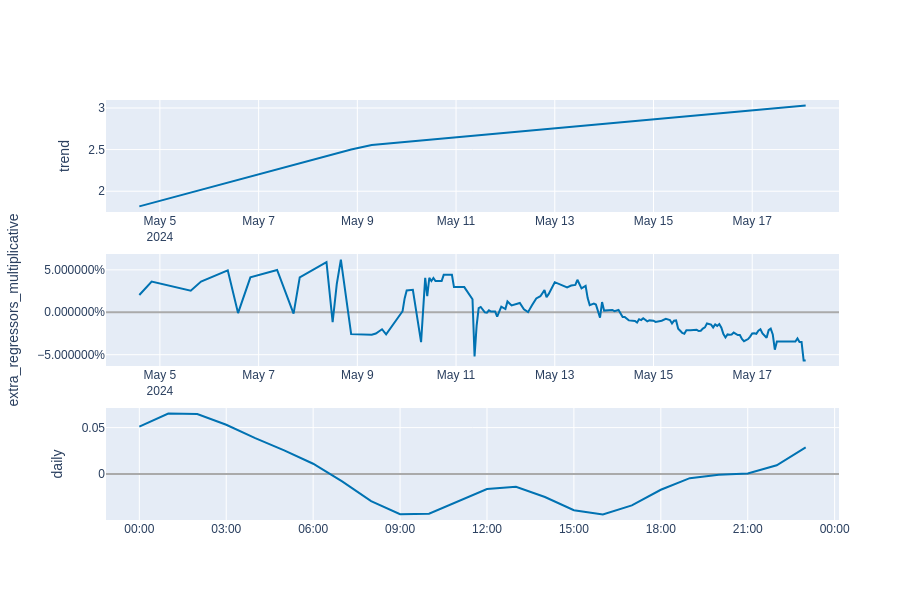

In [8]:
plot_components_plotly(m, forecast)

In [9]:
df_cv = cross_validation(m, initial='2 hour', period='15 hour', horizon = '6 hour')
df_cv.head()

Seasonality has period of 1 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/16 [00:00<?, ?it/s]

10:17:46 - cmdstanpy - INFO - Chain [1] start processing
10:17:49 - cmdstanpy - INFO - Chain [1] done processing
10:17:49 - cmdstanpy - INFO - Chain [1] start processing
10:17:51 - cmdstanpy - INFO - Chain [1] done processing
10:17:51 - cmdstanpy - INFO - Chain [1] start processing
10:17:51 - cmdstanpy - INFO - Chain [1] done processing
10:17:51 - cmdstanpy - INFO - Chain [1] start processing
10:17:51 - cmdstanpy - INFO - Chain [1] done processing
10:17:51 - cmdstanpy - INFO - Chain [1] start processing
10:17:51 - cmdstanpy - INFO - Chain [1] done processing
10:17:51 - cmdstanpy - INFO - Chain [1] start processing
10:17:51 - cmdstanpy - INFO - Chain [1] done processing
10:17:52 - cmdstanpy - INFO - Chain [1] start processing
10:17:52 - cmdstanpy - INFO - Chain [1] done processing
10:17:52 - cmdstanpy - INFO - Chain [1] start processing
10:17:52 - cmdstanpy - INFO - Chain [1] done processing
10:17:52 - cmdstanpy - INFO - Chain [1] start processing
10:17:52 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2024-05-05 15:00:00,6.442270,6.442270,6.442270,2.02,2024-05-05 14:00:00
1,2024-05-05 20:00:00,5.473830,5.473830,5.473830,2.03,2024-05-05 14:00:00
2,2024-05-06 20:00:00,2.186998,2.186998,2.186998,2.20,2024-05-06 14:00:00
3,2024-05-07 17:00:00,-1.087497,-1.094760,-1.079837,2.35,2024-05-07 14:00:00
4,2024-05-07 20:00:00,2.399237,2.391616,2.406338,2.40,2024-05-07 14:00:00


In [80]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 01:00:00,4.308703,2.075741,0.837376,0.401327,0.028798,0.188328,0.500000
1,0 days 02:00:00,0.012568,0.112109,0.085316,0.031516,0.021089,0.030679,0.600000
2,0 days 03:00:00,1.708850,1.307230,0.604628,0.250845,0.044941,0.327748,0.285714
3,0 days 04:00:00,0.027090,0.164590,0.150858,0.055904,0.059033,0.055022,0.166667
4,0 days 05:00:00,0.058639,0.242154,0.220963,0.083653,0.073260,0.086281,0.000000


/home/dell/anaconda3/envs/flood-rs/lib/python3.12/site-packages/prophet/plot.py:546: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.

/home/dell/anaconda3/envs/flood-rs/lib/python3.12/site-packages/prophet/plot.py:547: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



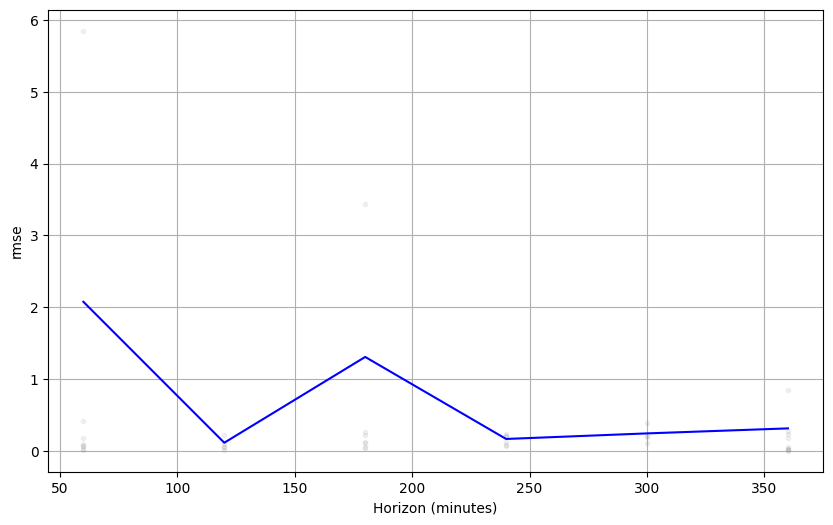

In [81]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [82]:
with open('data/serialized_model.json', 'w') as fout:
    fout.write(model_to_json(m))